# Sampling Approach
-------------

[<img src="../img/bdc.png" alt="BDC" width="200" align="right">](http://brazildatacube.org/about-brazil-data-cube/)

## Author:
 - Leonardo de Souza Vieira

## Adivisors
 - Dr. Gilberto Ribeiro de Queiroz
 - Dr. Elcio Hideiti Shiguemori
------------

# 1. Introduction

---------

The python codes using a list of packages, where each package is used in a specific development step. Bellow we show short description of the used packages

<ul>
    <li><a href='https://gdal.org/'>GDAL</a>: Manipulation of geospatial data, vetor and raster;</li>
    <li><a href='https://pandas.pydata.org/'>Pandas</a>: Data Science;</li>
    <li><a href='https://geopandas.org/'>GeoPandas</a>: Analysis of vector type geospatial data;</li>
    <li><a href='https://rasterio.readthedocs.io/en/latest/'>Rasterio</a>: Manipulation of geospatial data raster type;</li>
    <li><a href='https://pyproj4.github.io/pyproj/stable/'>PyPROJ</a>: Python interface to cartographic projections;</li>
    <li><a href='https://pypi.org/project/psycopg2/'>Psycopg </a>: PostgreSQL Data base conection;</li>
    <li><a href='https://numpy.org/'>Numpy</a> Numerical computations, matrix n-dimensional;</li>
    <li><a href='https://matplotlib.org/'>Matplotlib</a>: Creating static, animated, and interactive visualizations in Python. </li>
</ul>

Besides this packages also is imported some python functions that can be see it in "sampling_geodb.py". The next cell show how we can import the packages and python functions.

In [1]:
from datetime import datetime
import geopandas as gpd
import json
import matplotlib
import numpy as np
import pandas as pd
import pyproj
import psycopg2
import rasterio
# import stac
from typing import List, Dict
from matplotlib import pyplot as plt
from osgeo import gdal
from rasterio import features
from shapely import wkt
from matplotlib import pyplot
from sampling_geodb import  get_bbox,conn_db,get_items, sampling, rasterize_gdf
import warnings
warnings.filterwarnings('ignore')

-------------

## <span style="color:#336699; font-size: 80%; text-decoration:underline;"> BDC data base conection  </span>

The study development uses PRODES geodata in the sampling. The geodata was stored in a Postgis server available by Brazil Data Cube project. All Prodes data can be downloaded at Terrabrasilis portal (href='http://terrabrasilis.dpi.inpe.br/downloads/). The cell bellow uses the function conn_db() to connect at the PRODES database used in all study.  

In [106]:
pg_conn = conn_db('../data/json/my_pass.json')

crs_bdc = pyproj.CRS("+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs")

-------------

## <span style="color:#336699; font-size: 80%; text-decoration:underline;"> Region of Interest (ROI) </span>

The ROI are the state of 'Rondônia', Brazil. The region was suffering with intense deforestation at the last years. Rondônia is one of the Brazilian states that deforest the most, and have proportionally the largest rate considering the area of state and the deforestation area. Also, the State no  are so large like Amazonas or Para (other states with great rate of deforestation), we consider that would make it difficult make it difficult this initial analysis. Bellow we present the ROI using Legal Amazon Forest over Brazil at referee.

In [3]:
# Define the projection used in the BDC grids
# crs_bdc = pyproj.CRS("+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs")

# Obtain data of Brazil Biomes
query_legal_amazon = "SELECT gid, id, nome, geom FROM ibge.biomas WHERE nome = 'Amazônia';"
brazil_bla_gdf = gpd.read_postgis( sql=query_legal_amazon, con=pg_conn, crs=crs_bdc)

# Obtain data of Brazil States
query_brazil_states = "SELECT gid, __gid, cd_uf, nm_uf,sigla_uf,nm_regiao, geom FROM ibge.uf_2020;"
brazil_states_gdf = gpd.read_postgis( sql=query_brazil_states, con=pg_conn, crs=crs_bdc)

sql_roi = "WITH geom_buffer AS (SELECT ST_BUFFER(geom, 90000) AS geom FROM bdc.bdc_sm_v2 WHERE tile = '013015') \
           SELECT ST_TRANSFORM(ST_UNION(bdc.geom), 4674)  AS geom \
                FROM bdc.bdc_sm_v2 AS bdc, geom_buffer \
           WHERE ST_INTERSECTS(bdc.geom, geom_buffer.geom);"

# crs_bdc = pyproj.CRS("+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs")
sql_roi = "WITH geom_buffer AS (SELECT ST_BUFFER(geom, 150000,2000) AS geom FROM bdc.bdc_sm_v2 WHERE tile = '013015') \
           SELECT bdc.gid AS gid, bdc.tile AS tile, ST_TRANSFORM(bdc.geom, 4326)  AS geom \
                FROM bdc.bdc_sm_v2 AS bdc, geom_buffer \
           WHERE ST_INTERSECTS(bdc.geom, geom_buffer.geom);"

roi_gdf = gpd.read_postgis( sql=sql_roi, con=pg_conn, crs=4326)

sql_grid = "WITH geom_buffer AS (SELECT ST_BUFFER(geom, 90000) AS geom FROM bdc.bdc_sm_v2 WHERE tile = '013015') \
           SELECT bdc.gid AS gid, bdc.tile AS tile, ST_TRANSFORM(bdc.geom, 4674) AS geom \
                FROM bdc.bdc_sm_v2 AS bdc, geom_buffer \
           WHERE ST_INTERSECTS(bdc.geom, geom_buffer.geom);"


grid_gdf = gpd.read_postgis( sql=sql_grid, con=pg_conn, crs=4674)

--------

### <span style="color:#336699; font-size: 80%; text-decoration:underline;"> Plot Map </span>

The next cell show how we can to plot the geodata. The code uses the dataframes obtained above.

<AxesSubplot:title={'center':'ROI in Brazilian Legal Amazon (BLA)'}>

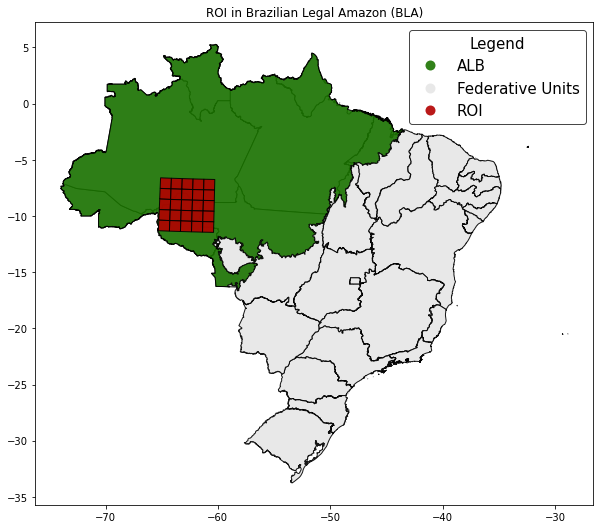

In [4]:
# Create Labels to Map plot
brazil_bla_gdf["label_plot"] = "ALB"
brazil_states_gdf["label_plot"] = "Federative Units"
rondonia_gdf = brazil_states_gdf.loc[brazil_states_gdf['sigla_uf'] == 'RO']
roi_gdf["label_plot"] = "ROI"

# Create collor map to plot
colors = [ (0.1, 0.45, 0.0),(0.9,0.9,0.9), (0.7, 0.0, 0.0)]
cmap_name = 'legendROI'
mycmap = matplotlib.colors.ListedColormap(colors, name=cmap_name, N=3)

# Create the plot geometries list.

to_plot_legend_gdf = pd.concat([brazil_states_gdf, brazil_bla_gdf, roi_gdf])

# Map plot
fig, ax = plt.subplots(figsize=(10,10))

ax.set_title(u'ROI in Brazilian Legal Amazon (BLA)')
to_plot_legend_gdf.plot(ax=ax, 
                        edgecolor='black',
                        column='label_plot',
                        cmap = mycmap,
                        legend=True,
                        alpha=0.9,
                        legend_kwds={'edgecolor': '0.1', 'title_fontsize': 15, 'fontsize': 15, 'title': "Legend"} )

--------------
## Reference data
--------------
### PRODES 2018 - Deforestation

In [5]:
deforestation_roi_2018 = {}
for t in roi_gdf['tile']:
    sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format(t, 'incremento_anual', 2018)
    deforestation_gpd = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)
    deforestation_roi_2018[t] = deforestation_gpd

--------------
### PRODES 2021 - Forest

In [6]:
forest_roi_2021 = {}
for t in roi_gdf['tile']:
    sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format(t, 'floresta_anual', 2021)
    forest_gpd = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)
    forest_roi_2021[t] = forest_gpd

------------
### Start and End Date for time series (reference tile 013015)

In [7]:
start_date = deforestation_roi_2018['013015']['image_date'].max()
end_date = forest_roi_2021['013015']['image_date'].min()

In [8]:
print('Period: ' + str(start_date) + ' to '+ str(end_date))

Period: 2018-07-24 to 2021-07-16


------------
### Adding class id

In [128]:
for t in roi_gdf['tile']:
    deforestation_roi_2018[t]['class_id']= 1
    forest_roi_2021[t]['class_id']= 0

------
### Rasterizing the sampling area

In [30]:
dir_save = '../data/prodes/reference_data/'
dir_ref_images = '../data/imagens/S2-16D-2/'
for t in roi_gdf['tile']:
    composed = pd.concat([deforestation_roi_2018[t],
                          forest_roi_2021[t]], ignore_index=True)
    rasterize_gdf(composed,
                  'class_id',
                  dir_ref_images + 'S2-16D_V2_'+ t +'_20170101_NDVI.tif',
                  dir_save + 'S2_10_PRODES_2018_2021_'+ t +'.tif')

------
### Plot composed PRODES 2018-2021

<AxesSubplot:title={'center':'PRODES Composed 2018-2021'}>

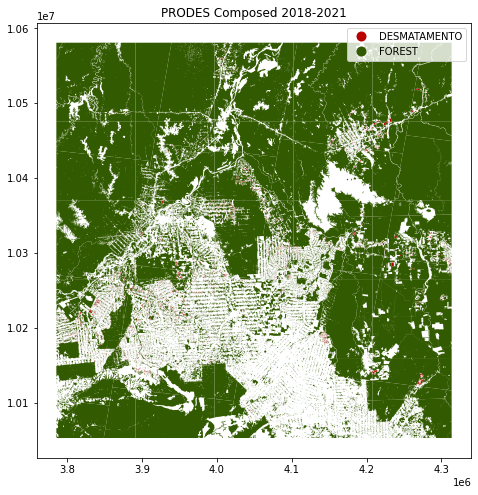

In [35]:
gdf_values = list()
for t in roi_gdf['tile']:
    gdf_values.append(deforestation_roi_2018[t])
    gdf_values.append(forest_roi_2021[t])
    
composed = pd.concat(gdf_values, ignore_index=True)

colors = [(0.73, 0.0, 0.0), (0.19607843137254902, 0.35294117647058826, 0.0),(0.7, 0.7, 0.7) ]
cmap_name = 'prodes_legend'

mycmap = matplotlib.colors.ListedColormap(colors, name=cmap_name, N=2)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('PRODES Composed 2018-2021')
composed.plot(ax=ax, column = 'main_class',  cmap = mycmap,legend=True)

------
### Sampling composed PRODES 2018-2021

In [10]:
samples_tiles = []
n_samples = 0
for tile in roi_gdf['tile']:
    for label in [0, 1]:
        n_samples = 10000
        samples_tiles.append(sampling('../data/prodes/reference_data/S2_10_PRODES_2018_2021_'+ tile + '.tif',
                                label,
                                "2018-07-24",
                                "2021-07-16",
                                "random",
                                True,
                                n_samples))
samples = pd.concat(samples_tiles, ignore_index=True)
samples.to_csv("../data/csv/samples_2019-2021.csv",index=True)

## Test samples
--------------
### PRODES 2018 - Deforestation

In [11]:
deforestation_roi_2018 = {}
for t in roi_gdf['tile']:
    sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format(t, 'incremento_anual', 2018)
    deforestation_gpd = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)
    deforestation_roi_2018[t] = deforestation_gpd

--------------
### PRODES 2019 - Deforestation

In [12]:
deforestation_roi_2019 = {}
for t in roi_gdf['tile']:
    sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format(t, 'incremento_anual', 2019)
    deforestation_gpd = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)
    deforestation_roi_2019[t] = deforestation_gpd

--------------
### PRODES 2021 - Deforestation

In [13]:
deforestation_roi_2020 = {}
for t in roi_gdf['tile']:
    sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format(t, 'incremento_anual', 2020)
    deforestation_gpd = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)
    deforestation_roi_2020[t] = deforestation_gpd

In [15]:
for t in roi_gdf['tile']:
    deforestation_roi_2018[t]['class_id']= 2018
    deforestation_roi_2019[t]['class_id']= 2019
    deforestation_roi_2020[t]['class_id']= 2020
    
    
dir_save = '../data/prodes/test_data/'
dir_ref_images = '../data/imagens/S2-16D-2/'
for t in roi_gdf['tile']:
    composed = pd.concat([deforestation_roi_2019[t], 
                          deforestation_roi_2020[t],
                          deforestation_roi_2021[t]], ignore_index=True)
    rasterize_gdf(composed,
                  'class_id',
                  dir_ref_images + 'S2-16D_V2_'+ t +'_20170101_NDVI.tif',
                  dir_save + 'S2_10_PRODES_2018_2019_2020_deforestation_'+ t +'.tif')

In [17]:
samples_tiles = []
n_samples = 0

dates = {2018: ["2018-07-28", "2019-07-12"],
        2019: ["2019-07-28", "2020-07-11"],
        2020: ["2020-07-27","2021-07-12"]}
for label in [2018, 2019, 2020]:
    for tile in roi_gdf['tile']:
        n_samples = 10000
        samples_tiles.append(sampling('../data/prodes/test_data/S2_10_PRODES_2019_2020_2021_deforestation_'+ tile + '.tif',
                                label,
                                dates[label][0],
                                dates[label][1],
                                "random",
                                True,
                                n_samples))
    samples = pd.concat(samples_tiles, ignore_index=True)
    samples.to_csv("../data/csv/samples_" + "deforestation_" + dates[label][0] + "_" + dates[label][1]+ ".csv",index=True)

--------------
## PRODES mapping all time

### Database tables

In [107]:
query = "SELECT table_name  FROM   information_schema.tables WHERE  table_catalog = 'geodb'  AND    table_schema = 'prodes';"

cursor = pg_conn.cursor()

cursor.execute(query)
mobile_records = cursor.fetchall()
cursor.close()
print(mobile_records)

[('floresta_anual',), ('desmatamento_acumulado',), ('nuvem',), ('nao_floresta',), ('hidrografia',), ('incremento_anual',)]


### Deforestation increment years

In [109]:
query = "SELECT DISTINCT(year)  FROM   prodes.incremento_anual"

cursor = pg_conn.cursor()

cursor.execute(query)
mobile_records = cursor.fetchall()
cursor.close()
print(mobile_records)

[(2008,), (2009,), (2010,), (2011,), (2012,), (2013,), (2014,), (2015,), (2016,), (2017,), (2018,), (2019,), (2020,)]


### Deforestation increment

In [160]:
years = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
deforestation_gdf = []
for y in years:
    print(y)
    deforestation_roi = {}
    for t in roi_gdf['tile']:
        sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format(t, 'incremento_anual', y)
        deforestation_gpd = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)
        deforestation_roi[t] = deforestation_gpd
        deforestation_roi[t]['class_id']= y
    deforestation_gdf.append(deforestation_roi)

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


### Deforestation accumulated

In [111]:
deforestation_accumulated = {}
for t in roi_gdf['tile']:
    query = "SELECT prodes.gid AS gid, prodes.id AS id, prodes.origin_id AS origin_id, prodes.state AS state, \
                                 prodes.path_row AS path_row, prodes.main_class AS main_class, prodes.class_name AS class_name, \
                                 prodes.def_cloud AS def_cloud, prodes.julian_day AS julian_day, prodes.image_date AS image_date, \
                                 prodes.year AS year, prodes.area_km AS area_km, prodes.scene_id AS scene_id, prodes.source AS source, \
                                 prodes.satellite AS satellite, prodes.sensor AS sensor, \
                                 ST_TRANSFORM( \
                                    ST_INTERSECTION(prodes.geom::geometry(Polygon,4674), \
                                    (SELECT ST_TRANSFORM(grid.geom, 4674) FROM bdc.bdc_sm_v2 AS grid WHERE grid.tile = \'{}\'))\
                                , 100010) AS geom\
                       FROM prodes.desmatamento_acumulado AS prodes \
                       WHERE \
                           ST_INTERSECTS(prodes.geom::geometry(Polygon,4674),\
                                     (SELECT ST_TRANSFORM(grid.geom, 4674) FROM bdc.bdc_sm_v2 AS grid WHERE grid.tile = \'{}\')); ".format(t,t)
    deforestation_accumulated_gpd = gpd.read_postgis(sql=query, crs=crs_bdc, con=pg_conn)
    deforestation_accumulated[t] = deforestation_accumulated_gpd
    deforestation_accumulated[t]['class_id']= 2007

### Hydrography

In [112]:
hidrografia = {}
for t in roi_gdf['tile']:
    query = "SELECT prodes.gid AS gid, prodes.id AS id, prodes.origin_id AS origin_id, prodes.state AS state, \
                                 prodes.path_row AS path_row, prodes.main_class AS main_class, prodes.class_name AS class_name, \
                                 prodes.def_cloud AS def_cloud, prodes.julian_day AS julian_day, prodes.image_date AS image_date, \
                                 prodes.year AS year, prodes.area_km AS area_km, prodes.scene_id AS scene_id, prodes.source AS source, \
                                 prodes.satellite AS satellite, prodes.sensor AS sensor, \
                                 ST_TRANSFORM( \
                                    ST_INTERSECTION(prodes.geom::geometry(Polygon,4674), \
                                    (SELECT ST_TRANSFORM(grid.geom, 4674) FROM bdc.bdc_sm_v2 AS grid WHERE grid.tile = \'{}\'))\
                                , 100010) AS geom\
                       FROM prodes.hidrografia AS prodes \
                       WHERE \
                           ST_INTERSECTS(prodes.geom::geometry(Polygon,4674),\
                                     (SELECT ST_TRANSFORM(grid.geom, 4674) FROM bdc.bdc_sm_v2 AS grid WHERE grid.tile = \'{}\')); ".format(t,t)
    hidrografia_gpd = gpd.read_postgis(sql=query, crs=crs_bdc, con=pg_conn)
    hidrografia[t] = hidrografia_gpd
    hidrografia[t]['class_id']= 6

### No Forest (Other type of natural land cover ex: rocky mountains)

In [118]:
nao_floresta = {}
for t in roi_gdf['tile']:
    query = "SELECT prodes.gid AS gid, prodes.id AS id, prodes.origin_id AS origin_id, prodes.state AS state, \
                                 prodes.path_row AS path_row, prodes.main_class AS main_class, prodes.class_name AS class_name, \
                                 prodes.def_cloud AS def_cloud, prodes.julian_day AS julian_day, prodes.image_date AS image_date, \
                                 prodes.year AS year, prodes.area_km AS area_km, prodes.scene_id AS scene_id, prodes.source AS source, \
                                 prodes.satellite AS satellite, prodes.sensor AS sensor, \
                                 ST_TRANSFORM( \
                                    ST_INTERSECTION(prodes.geom::geometry(Polygon,4674), \
                                    (SELECT ST_TRANSFORM(grid.geom, 4674) FROM bdc.bdc_sm_v2 AS grid WHERE grid.tile = \'{}\'))\
                                , 100010) AS geom\
                       FROM prodes.nao_floresta AS prodes \
                       WHERE \
                           ST_INTERSECTS(prodes.geom::geometry(Polygon,4674),\
                                     (SELECT ST_TRANSFORM(grid.geom, 4674) FROM bdc.bdc_sm_v2 AS grid WHERE grid.tile = \'{}\')); ".format(t,t)
    nao_floresta_gpd = gpd.read_postgis(sql=query, crs=crs_bdc, con=pg_conn)
    nao_floresta[t] = nao_floresta_gpd
    nao_floresta[t]['class_id']= 7

### Forest 2021

In [113]:
forest_roi_2021 = {}
for t in roi_gdf['tile']:
    sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format(t, 'floresta_anual', 2021)
    forest_gpd = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)
    forest_roi_2021[t] = forest_gpd
    forest_roi_2021[t]['class_id']= 0

## Plot map

<AxesSubplot:title={'center':'PRODES Composed 2018-2021'}>

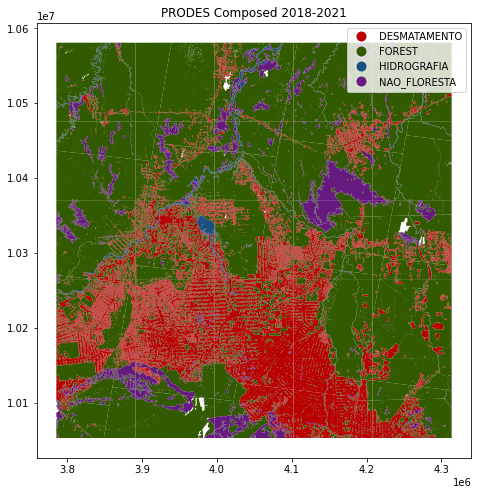

In [161]:
gdf_values = list()
for t in roi_gdf['tile']:
    gdf_values.append(deforestation_accumulated[t])
    gdf_values.append(forest_roi_2021[t])
    gdf_values.append(hidrografia[t])
    gdf_values.append(nao_floresta[t])
    for deforestaion_increment in deforestation_gdf:
        gdf_values.append(deforestaion_increment[t])
    
composed = pd.concat(gdf_values, ignore_index=True)

colors = [(0.73, 0.0, 0.0),
          (0.19607843137254902, 0.35294117647058826, 0.0),
          (0.1, 0.3, 0.5),
          (0.4, 0.1, 0.5)
         ]
cmap_name = 'prodes_legend'

mycmap = matplotlib.colors.ListedColormap(colors, name=cmap_name, N=4)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('PRODES Composed 2018-2021')
composed.plot(ax=ax, column = 'main_class',  cmap = mycmap,legend=True)

In [146]:
hidrografia['013015']['class_id']

0      6
1      6
2      6
3      6
4      6
      ..
182    6
183    6
184    6
185    6
186    6
Name: class_id, Length: 187, dtype: int64

In [159]:
dir_save = '../data/prodes/map/'
dir_ref_images = '../data/imagens/S2-16D-2/'

for t in roi_gdf['tile']:
    prodes_map = pd.concat([deforestation_accumulated[t],
                            forest_roi_2021[t],
                            hidrografia[t],
                            nao_floresta[t]])
    for deforestaion_increment in deforestation_gdf:
        prodes_map = pd.concat([prodes_map, deforestaion_increment[t]])
    prodes_map = prodes_map.astype({"class_id":"int32"})
    rasterize_gdf(prodes_map,
                  'class_id',
                  dir_ref_images + 'S2-16D_V2_'+ t +'_20170101_NDVI.tif',
                  dir_save + 'S2_10_PRODES_2007_2021_'+ t +'.tif')